# Capstone Three: Data Wrangling and EDA

## Overview

In this notebook, we will be using time series data from the US Census Bureau and the US Bureau of Economic Analysis. The first dataset was downloaded from Kaggle [at this link](https://www.kaggle.com/datasets/census/population-time-series-data?resource=download&select=total-population-all-ages-including-armed-forces-overseas_metadata.json), and includes the population of the United States on the first of the month, every month, from January 1952 to December 2019. The second data set was downloaded from the Federal Reserve Economic Data [at this link](https://fred.stlouisfed.org/series/A939RX0Q048SBEA), and includes the GDP per capita quarterly of the United States from January 1947 to July 2022. We are going to make sure that our data is clean and see what shape we are working with.

## 1. Importing our tools

### 1a. Importing useful packages

In [1]:
#Bringing in pandas and matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt

### 1b. Importing Relevant Data

In [2]:
raw_data = pd.read_csv('../data/raw/POP.csv')
gdp_data = pd.read_csv('../data/raw/gdpcap.csv')

## 2. Cleaning and transforming

### 2a. Dropping unwanted columns

In [3]:
#Let's see how the population dataset looks to start
raw_data.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


The realtime start and realtime end columns don't look very useful, so let's start by dropping those.

In [4]:
raw_data = raw_data.drop(['realtime_start', 'realtime_end'], axis = 1)

In [5]:
raw_data.head()

,value,date
0,156309.0,1952-01-01
1,156527.0,1952-02-01
2,156731.0,1952-03-01
3,156943.0,1952-04-01
4,157140.0,1952-05-01


In [6]:
#and again for the gdp per capita
gdp_data.head()

,DATE,A939RX0Q048SBEA
0,1947-01-01,14213.0
1,1947-04-01,14111.0
2,1947-07-01,14018.0
3,1947-10-01,14171.0
4,1948-01-01,14326.0


Looks good here!

### 2b. Column Types and setting our index

For the population data, we should make sure that we have one datetime column and one integer column.

In [7]:
#Check what kind of data types we already have
raw_data.dtypes

value    float64
date      object
dtype: object

In [8]:
#Change date column to datetime object and set as index
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index('date', inplace = True)

In [9]:
#Change value column to integer
raw_data['value'] = raw_data['value'].astype(int)

In [10]:
raw_data.dtypes

value    int32
dtype: object

Again for the GDP data, we want one datetime column and one integer column. First, let's change the column names so they match the population dataset. 

In [11]:
#Change gdp dataset column names to match population dataset
gdp_data.rename(columns = {'DATE': 'date', 'A939RX0Q048SBEA': 'value'}, inplace = True)

In [12]:
gdp_data.columns

Index(['date', 'value'], dtype='object')

In [13]:
gdp_data.dtypes

date      object
value    float64
dtype: object

In [14]:
#Change date column to datetime object and set as index
gdp_data['date'] = pd.to_datetime(gdp_data['date'])
gdp_data.set_index('date', inplace = True)

In [15]:
gdp_data['value'] = gdp_data['value'].astype(int)

In [16]:
gdp_data.dtypes

value    int32
dtype: object

### 2c. Match dataset time frames

Since our GDP dataset is measured quarterly, we need our population dataset to be quarterly as well. We also need the GDP dataset to be within the same range as the population dataset. 

In [17]:
#Make population data quarterly
raw_data = raw_data[raw_data.index.month.isin([1, 4, 7, 10])]
raw_data.head(5)

,value
date,
1952-01-01,156309
1952-04-01,156943
1952-07-01,157553
1952-10-01,158306
1953-01-01,158973


In [18]:
#Make GDP data the correct date range
gdp_data = gdp_data[gdp_data.index >= '1952-01-01']
gdp_data = gdp_data[gdp_data.index <= '2019-10-01']

In [19]:
#Check to make sure they are both the same size
print(raw_data.shape)
print(gdp_data.shape)

(272, 1)
(272, 1)


### 2d. Checking for errors

If only for peace of mind, let's see if there are any missing values

In [20]:
missing = pd.concat([raw_data.isnull().sum(), 100 * raw_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
value,0,0.0


In [21]:
missing1 = pd.concat([gdp_data.isnull().sum(), 100 * gdp_data.isnull().mean()], axis=1)
missing1.columns=['count', '%']
missing1.sort_values(by='count', ascending = False)

,count,%
value,0,0.0


### 2e. Visualize the data

Our data was already very clean when we got it, so let's see what it looks like when visualized.

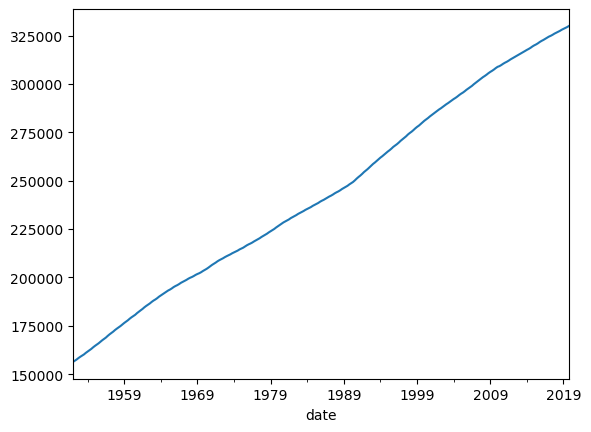

In [22]:
y = raw_data['value']
y.plot()
plt.show()

We can clearly see the population trending upwards as the years go on fairly consistently.

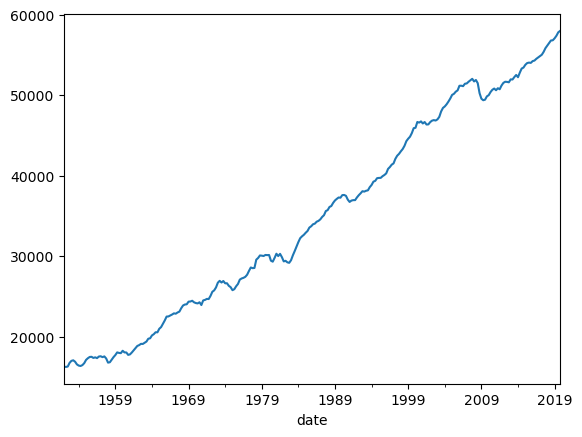

In [23]:
y1 = gdp_data['value']
y1.plot()
plt.show()

The gdp is a little bit less linear than the population data, but we still do see a positive correlation.

Next, I am going to use statsmodels' STL method to track better understand the seasonality and noise of these datasets.

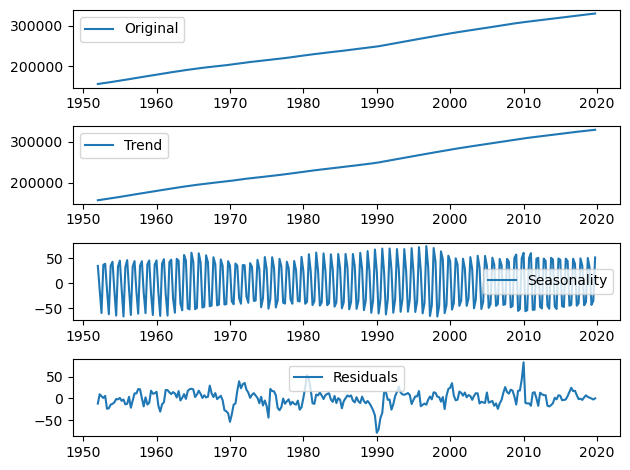

In [24]:
from statsmodels.tsa.seasonal import STL

raw_data = raw_data.asfreq('QS', how = 'start')
stl = STL(raw_data).fit()

trend = stl.trend
seasonal = stl.seasonal
residual = stl.resid

plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

On the population side, we see a positive trend all the way through with some seasonality. 

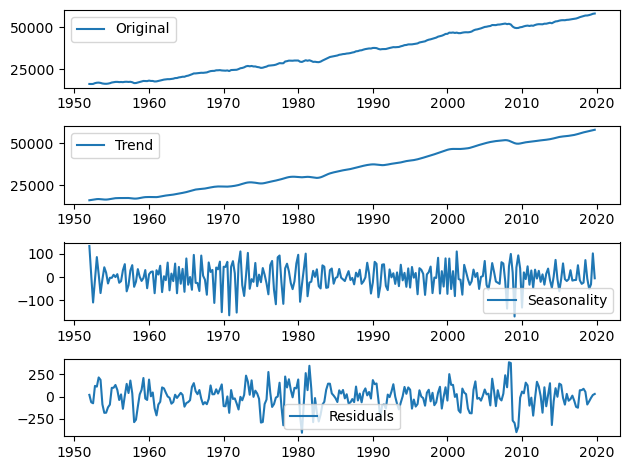

In [25]:
gdp_data = gdp_data.asfreq('QS', how = 'start')
stl1 = STL(gdp_data).fit()

trend1 = stl1.trend
seasonal1 = stl1.seasonal
residual1 = stl1.resid

plt.subplot(411)
plt.plot(y1, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend1, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal1, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual1, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

Here, we again see a postive trend. We have a much more inconsistent seasonality this time however.

## 3. Detrending for stationarity

Many highly effective time series models require stationary data. Since both our population data and GDP data are not stationary, we will have to detrend both of those datasets. First, let's look at the population data.

For the population data, the variance and covariance are fairly consistent, but the mean increases over time. To make the data stationary, we will likely have to take the difference of the values from each other. First, I will use a kpss test to make sure that the data actually isn't stationary.

In [26]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.568585848956028,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The null hypothesis here is that the data is stationary. With a p-value of less than .05, we reject the null hypothesis and confirm that the data is not stationary. I will take the difference of the data and see how that does.

In [27]:
raw_data['value_diff'] = raw_data['value'].diff()
kpss(raw_data['value_diff'].dropna())

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.23823252531207248,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

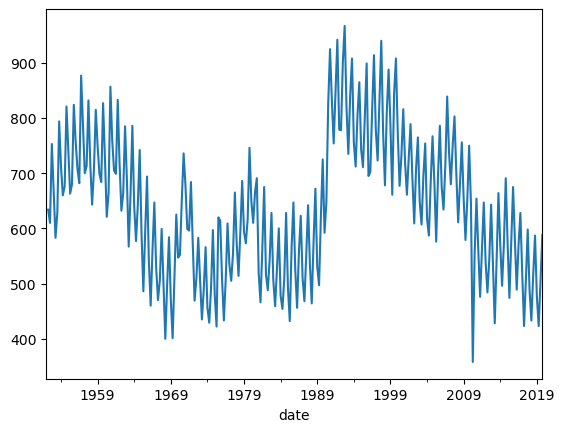

In [28]:
raw_data['value_diff'].plot()
plt.show()

This null hypothesis is not rejected this time, however the data is in a bit of a weird spot. I'd like to take the difference one more time so that there are less peaks and vallies.

In [29]:
raw_data['value_diff2'] = raw_data['value_diff'].diff()
kpss(raw_data['value_diff2'].dropna())

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08529739176372232,
 0.1,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

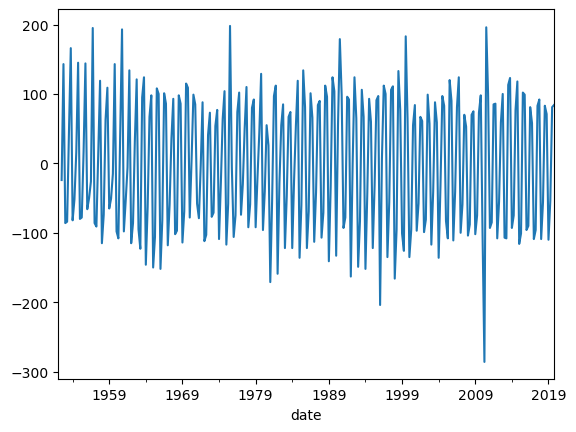

In [30]:
raw_data['value_diff2'].plot()
plt.show()

As we can see from both the plot and the kpss model, our population data is now stationary. Now, lets do the same for the GDP data.

In [31]:
kpss(y1)

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.5695104308126058,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Again, the null hypothesis is rejected, and we can conclude that the raw data is not stationary. Let's try taking the difference of the data and see how things look.

In [32]:
gdp_data['value_diff'] = gdp_data['value'].diff()
kpss(gdp_data['value_diff'].dropna())

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.19609022234296272,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

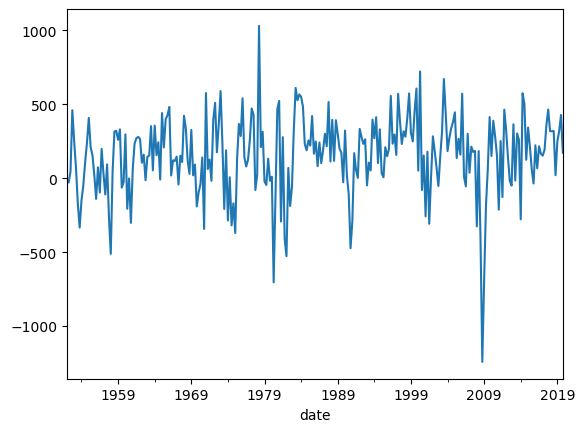

In [33]:
gdp_data['value_diff'].plot()
plt.show()

The GDP data looks stationary after just one difference, which is very helpful to us.

In [34]:
raw_data.to_csv(r'C:/Users/Anthony/Springboard/CapstoneThree/data/clean/pop_data.csv', index = True)

In [35]:
gdp_data.to_csv(r'C:/Users/Anthony/Springboard/CapstoneThree/data/clean/gdp_data.csv', index = True)